# Activity: Build a decision tree

## Introduction

A decision tree model can makes predictions for a target based on multiple features. Because decision trees are used across a wide array of industries, becoming proficient in the process of building one will help you expand your skill set in a widely-applicable way.   

For this activity, you work as a consultant for an airline. The airline is interested in predicting whether a future customer would be satisfied with their services given customer feedback given previous customer feedback about their flight experience. The airline would like you to construct and evaluate a model that can accomplish this goal. Specifically, they are interested in knowing which features are most important to customer satisfaction.

The data for this activity includes survey responses from 129,880 customers. It includes data points such as class, flight distance, and in-flight entertainment, among others. In a previous activity, you utilized a binomial logistic regression model to help the airline better understand this data. In this activity, your goal will be to utilize a decision tree model to predict whether or not a customer will be satisfied with their flight experience. 

Because this activity uses a dataset from the industry, you will need to conduct basic EDA, data cleaning, and other manipulations to prepare the data for modeling.

In this activity, you’ll practice the following skills:

* Importing packages and loading data
* Exploring the data and completing the cleaning process
* Building a decision tree model 
* Tuning hyperparameters using `GridSearchCV`
* Evaluating a decision tree model using a confusion matrix and various other plots

## Step 1: Imports

Import relevant Python packages. Use `DecisionTreeClassifier`,` plot_tree`, and various imports from `sklearn.metrics` to build, visualize, and evaluate the model.

### Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='white')

In [2]:
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

### Load the dataset

`Pandas` is used to load the **Invistico_Airline.csv** dataset. The resulting pandas DataFrame is saved in a variable named `df_original`. As shown in this cell, the dataset has been automatically loaded in for you. You do not need to download the .csv file, or provide more code, in order to access the dataset and proceed with this lab. Please continue with this activity by completing the following instructions.

In [3]:
df_original = pd.read_csv("Invistico_Airline.csv")

<details>
  <summary><h4><strong>Hint 1</strong></h4></summary>

Use a function from the pandas library to read in the csv file.
    
</details>

<details>
  <summary><h4><strong>Hint 2</strong></h4></summary>

Use the `read_csv` function and pass in the file name as a string. 

</details>

<details>
  <summary><h4><strong>Hint 3</strong></h4></summary>

Use `pd.read_csv("insertfilenamehere")`.

</details>

### Output the first 10 rows of data

In [4]:
df_original.head()

,satisfaction,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,2,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,3,...,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,3,...,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,3,...,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,3,...,4,2,2,0,2,4,2,5,0,0.0


<details>
  <summary><h4><strong>Hint 1</strong></h4></summary>

Use the `head()` function.

</details>

<details>
  <summary><h4><strong>Hint 2</strong></h4></summary>

If only five rows are output, it is because the function by default returns five rows. To change this, specify how many rows `(n = )` you want to output.

</details>

## Step 2: Data exploration, data cleaning, and model preparation

### Prepare the data

After loading the dataset, prepare the data to be suitable for decision tree classifiers. This includes: 

*   Exploring the data
*   Checking for missing values
*   Encoding the data
*   Renaming a column
*   Creating the training and testing data

### Explore the data

Check the data type of each column. Note that decision trees expect numeric data. 

In [5]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 22 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   satisfaction                       129880 non-null  object 
 1   Customer Type                      129880 non-null  object 
 2   Age                                129880 non-null  int64  
 3   Type of Travel                     129880 non-null  object 
 4   Class                              129880 non-null  object 
 5   Flight Distance                    129880 non-null  int64  
 6   Seat comfort                       129880 non-null  int64  
 7   Departure/Arrival time convenient  129880 non-null  int64  
 8   Food and drink                     129880 non-null  int64  
 9   Gate location                      129880 non-null  int64  
 10  Inflight wifi service              129880 non-null  int64  
 11  Inflight entertainment             1298

<details>
  <summary><h4><strong>Hint 1</strong></h4></summary>

Use the `dtypes` attribute on the DataFrame.
</details>

### Output unique values 

The `Class` column is ordinal (meaning there is an inherent order that is significant). For example, airlines typically charge more for 'Business' than 'Eco Plus' and 'Eco'. Output the unique values in the `Class` column. 

In [6]:
df_original['Class'].unique()

array(['Eco', 'Business', 'Eco Plus'], dtype=object)

<details>
  <summary><h4><strong> Hint 1 </strong></h4></summary>

Use the `unique()` function on the column `'Class'`.

</details>

### Check the counts of the predicted labels

In order to predict customer satisfaction, verify if the dataset is imbalanced. To do this, check the counts of each of the predicted labels. 

In [7]:
df_original['satisfaction'].value_counts().to_frame(name='Number')

,Number
satisfied,71087
dissatisfied,58793


In [8]:
df_original['satisfaction'].value_counts(normalize=True).round(2).to_frame(name='Percent')

,Percent
satisfied,0.55
dissatisfied,0.45


<details>
  <summary><h4><strong> Hint 1</strong> </h4></summary>

Use a function from the pandas library that returns a pandas series containing counts of unique values. 

</details>

<details>
  <summary><h4><strong> Hint 2</strong> </h4></summary>

Use the `value_counts()` function. Set the `dropna` parameter passed in to this function to `False` if you want to examine how many NaN values there are. 

</details>

**Question:** How many satisfied and dissatisfied customers were there?

Customer who `satisfied` is 71087 and who `dissatisfied` is 58793

**Question:** What percentage of customers were satisfied? 

Percentage respectively is 55% and 45%

### Check the number of rows and columns in the dataset

In [9]:
df_original.shape

(129880, 22)

<details>
  <summary><h4><strong> Hint 1 </strong> </h4></summary>

Use the `shape` attribute on the DataFrame.

</details>

- To understand the size and complexity of the dataset. The number of rows and columns can give you a good idea of how much data you are working with and how complex the dataset is. This information can be helpful in determining which machine learning algorithms are appropriate for the dataset and how much time and resources you need to invest in training and deploying a model.
- To identify data quality issues. If the number of rows and columns does not match, this could be a sign of a data quality issue. For example, if a column is missing data, the number of rows in the column will be less than the number of rows in the dataset. This can lead to problems when you try to train a machine learning model on the dataset.
- To troubleshoot problems with machine learning models. If a machine learning model is not performing as expected, checking the number of rows and columns can help you identify the source of the problem. For example, if a model is overfitting the training data, the number of rows in the training set may be too small.


**Question:** Why is it important to check how many rows and columns there are in the dataset?

### Check for missing values

The sklearn decision tree implementation does not support missing values. Check for missing values in the rows of the data. 

In [10]:
df_original.isna().sum()

satisfaction                           0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Seat comfort                           0
Departure/Arrival time convenient      0
Food and drink                         0
Gate location                          0
Inflight wifi service                  0
Inflight entertainment                 0
Online support                         0
Ease of Online booking                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Cleanliness                            0
Online boarding                        0
Departure Delay in Minutes             0
Arrival Delay in Minutes             393
dtype: int64

<details>
  <summary><h4><strong>Hint 1</h4></summary></strong>

Use the `isnull` function and the `sum` function. 

</details>

<details>
  <summary><h4><strong> Hint 2 </strong> </h4></summary>

To get the number of rows in the data with missing values, use the `isnull` function followed by the `sum` function.

</details>

### Drop the rows with missing values

Drop the rows with missing values and save the resulting pandas DataFrame in a variable named `df_subset`.

In [11]:
df_subset = df_original.dropna(axis=0)

<details>
  <summary><h4><strong> Hint 1 </strong> </h4></summary>

Use the `dropna` function.

</details>

<details>
  <summary><h4><strong>Hint 2</strong></h4></summary>

Set the axis parameter passed into the `dropna` function to `0` if you want to drop rows containing missing values, or `1` if you want to drop columns containing missing values. Optionally, use reset_index to avoid a SettingWithCopy warning later in the notebook. 

</details>

### Check for missing values

Check that `df_subset` does not contain any missing values.

In [12]:
df_subset.isna().any()

satisfaction                         False
Customer Type                        False
Age                                  False
Type of Travel                       False
Class                                False
Flight Distance                      False
Seat comfort                         False
Departure/Arrival time convenient    False
Food and drink                       False
Gate location                        False
Inflight wifi service                False
Inflight entertainment               False
Online support                       False
Ease of Online booking               False
On-board service                     False
Leg room service                     False
Baggage handling                     False
Checkin service                      False
Cleanliness                          False
Online boarding                      False
Departure Delay in Minutes           False
Arrival Delay in Minutes             False
dtype: bool

<details>
  <summary><h4><strong> Hint 1</strong></h4></summary>

Use the `isna()`function and the `sum()` function. 

</details>

<details>
  <summary><h4><strong> Hint 2</strong> </h4></summary>

To get the number of rows in the data with missing values, use the `isna()` function followed by the `sum()` function.

</details>

### Check the number of rows and columns in the dataset again

Check how many rows and columns are remaining in the dataset. You should now have 393 fewer rows of data.

In [13]:
df_subset.shape

(129487, 22)

### Encode the data

Four columns (`satisfaction`, `Customer Type`, `Type of Travel`, `Class`) are the pandas dtype object. Decision trees need numeric columns. Start by converting the ordinal `Class` column into numeric. 

In [14]:
df_subset[['satisfaction', 'Customer Type', 'Type of Travel', 'Class']].nunique()

satisfaction      2
Customer Type     2
Type of Travel    2
Class             3
dtype: int64

<details>
  <summary><h4><strong> Hint 1 </strong> </h4></summary>

Use the `map()` or `replace()` function. 

</details>

<details>
  <summary><h4><strong>Hint 2</strong></h4></summary>

For both functions, you will need to pass in a dictionary of class mappings `{"Business": 3, "Eco Plus": 2, "Eco": 1})`.

</details>

### Represent the data in the target variable numerically

To represent the data in the target variable numerically, assign `"satisfied"` to the label `1` and `"dissatisfied"` to the label `0` in the `satisfaction` column. 

In [15]:
label_encoder = LabelEncoder()

In [16]:
df_subset.loc[:, 'satisfaction'] = label_encoder.fit_transform(df_subset['satisfaction'])
df_subset.loc[:, 'Customer Type'] = label_encoder.fit_transform(df_subset['Customer Type'])
df_subset.loc[:, 'Type of Travel'] = label_encoder.fit_transform(df_subset['Type of Travel'])

C:\Users\Hp\AppData\Local\Temp\ipykernel_6528\2034183056.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.loc[:, 'satisfaction'] = label_encoder.fit_transform(df_subset['satisfaction'])
C:\Users\Hp\AppData\Local\Temp\ipykernel_6528\2034183056.py:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_subset.loc[:, 'satisfaction'] = label_encoder.fit_transform(df_subset['satisfaction'])
C:\Users\Hp\AppData\Local\Temp\ipykernel_6528\2034183056.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

<details>
  <summary><h4><strong> Hint 1 </strong> </h4></summary>

Use the `map()` function to assign existing values in a column to new values.

</details>

<details>
  <summary><h4><strong> Hint 2 </strong></h4></summary>

Call `map()` on the `satisfaction` column and pass in a dictionary specifying that `"satisfied"` should be assigned to `1` and `"dissatisfied"` should be assigned to `0`.

</details>

<details>
  <summary><h4><strong> Hint 3 </strong></h4></summary>

Update the `satisfaction` column in `df_subset` with the newly assigned values.

</details>

### Convert categorical columns into numeric

There are other columns in the dataset that are still categorical. Be sure to convert categorical columns in the dataset into numeric.

In [17]:
df_subset = pd.get_dummies(df_subset, columns=['Class'])

<details>
  <summary><h4><strong> Hint 1 </strong> </h4></summary>

Use the `get_dummies()` function. 

</details>

<details>
  <summary><h4><strong> Hint 2 </strong></h4></summary>

Set the `drop_first` parameter to `True`. This removes redundant data.

</details>

### Check column data types

Now that you have converted categorical columns into numeric, check your column data types.

In [18]:
df_subset.dtypes

satisfaction                           int32
Customer Type                          int32
Age                                    int64
Type of Travel                         int32
Flight Distance                        int64
Seat comfort                           int64
Departure/Arrival time convenient      int64
Food and drink                         int64
Gate location                          int64
Inflight wifi service                  int64
Inflight entertainment                 int64
Online support                         int64
Ease of Online booking                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Cleanliness                            int64
Online boarding                        int64
Departure Delay in Minutes             int64
Arrival Delay in Minutes             float64
Class_Business                         uint8
Class_Eco 

In [19]:
df_original.head()

,satisfaction,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,2,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,3,...,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,3,...,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,3,...,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,3,...,4,2,2,0,2,4,2,5,0,0.0


In [20]:
df_subset.head()

,satisfaction,Customer Type,Age,Type of Travel,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,...,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,Class_Business,Class_Eco,Class_Eco Plus
0,1,0,65,1,265,0,0,0,2,2,...,0,3,5,3,2,0,0.0,0,1,0
1,1,0,47,1,2464,0,0,0,3,0,...,4,4,2,3,2,310,305.0,1,0,0
2,1,0,15,1,2138,0,0,0,3,2,...,3,4,4,4,2,0,0.0,0,1,0
3,1,0,60,1,623,0,0,0,3,3,...,0,1,4,1,3,0,0.0,0,1,0
4,1,0,70,1,354,0,0,0,3,4,...,0,2,4,2,5,0,0.0,0,1,0


<details>
  <summary><h4><strong> Hint 1</strong></h4></summary>

Use the `dtypes` attribute on the DataFrame.

</details>

### Create the training and testing data

Put 75% of the data into a training set and the remaining 25% into a testing set. 

In [21]:
X = df_subset.drop("satisfaction", axis = 1).copy()

y= df_subset['satisfaction'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, 
                                                      test_size=0.25, 
                                                      random_state=42)

# 60 - 20 - 20

In [22]:
X.head()

,Customer Type,Age,Type of Travel,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,...,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,Class_Business,Class_Eco,Class_Eco Plus
0,0,65,1,265,0,0,0,2,2,4,...,0,3,5,3,2,0,0.0,0,1,0
1,0,47,1,2464,0,0,0,3,0,2,...,4,4,2,3,2,310,305.0,1,0,0
2,0,15,1,2138,0,0,0,3,2,0,...,3,4,4,4,2,0,0.0,0,1,0
3,0,60,1,623,0,0,0,3,3,4,...,0,1,4,1,3,0,0.0,0,1,0
4,0,70,1,354,0,0,0,3,4,3,...,0,2,4,2,5,0,0.0,0,1,0


<details>
  <summary><h4><strong> Hint 1</strong></h4></summary>

Use `train_test_split`.

</details>

<details>
  <summary><h4><strong> Hint 2</strong></h4></summary>

Pass in `0` to `random_state`.

</details>

<details>
  <summary><h4><strong>Hint 3</strong></h4></summary>

If you named your features matrix X and your target y, then it would be `train_test_split(X, y, test_size=0.25, random_state=0)`.

</details>

## Step 3: Model building

### Fit a decision tree classifier model to the data

Make a decision tree instance called `decision_tree` and pass in `0` to the `random_state` parameter. This is only so that if other data professionals run this code, they get the same results. Fit the model on the training set, use the `predict()` function on the testing set, and assign those predictions to the variable `dt_pred`. 

In [23]:
decision_tree = DecisionTreeClassifier(random_state=42)

# Fit the decision tree model on the training data
decision_tree = decision_tree.fit(X_train, y_train)

# Predict using the validation set (y_valid)
y_valid_pred = decision_tree.predict(X_valid)

<details>
  <summary><h4><strong> Hint 1</strong></h4></summary>

Use `DecisionTreeClassifier`, the `fit()` function, and the `predict()` function.

</details>

**Question:** What are some advantages of using decision trees versus other models you have learned about? 

- Interpretability: Decision trees are one of the most interpretable machine learning models. This means that you can easily understand how the model makes its predictions. This can be helpful for debugging the model and for explaining the model to stakeholders.
- Robustness to overfitting: Decision trees are relatively robust to overfitting. This means that they can often generalize well to new data, even if the training data is small or noisy.
- Flexibility: Decision trees can be used for both classification and regression tasks. They can also be used to handle mixed data types, which means that they can be used with both numerical and categorical features.
- Ease of use: Decision trees are relatively easy to use and implement. This makes them a good choice for beginners who are just starting to learn about machine learning.

## Step 4: Results and evaluation

Print out the decision tree model's accuracy, precision, recall, and F1 score.

In [24]:
print(classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     11760
           1       0.94      0.94      0.94     14138

    accuracy                           0.93     25898
   macro avg       0.93      0.93      0.93     25898
weighted avg       0.93      0.93      0.93     25898



In [25]:
print("Decision Tree")
print("Accuracy:", "%.6f" % accuracy_score(y_valid, y_valid_pred))
print("Precision:", "%.6f" % precision_score(y_valid, y_valid_pred))
print("Recall:", "%.6f" % recall_score(y_valid, y_valid_pred))
print("F1 Score:", "%.6f" % f1_score(y_valid, y_valid_pred))

Decision Tree
Accuracy: 0.933277
Precision: 0.939759
Recall: 0.937898
F1 Score: 0.938828


<details>
  <summary><h4><strong> Hint 1</strong></h4></summary>

Use four different functions from `metrics` to get the accuracy, precision, recall, and F1 score.
    
</details>

<details>
  <summary><h4><strong>Hint 2</strong></h4></summary>

Input `y_test` and `y_pred` into the `metrics.accuracy_score`, `metrics.precision_score`, `metrics.recall_score` and `metrics.f1_score` functions.
    
</details> 

**Question:** Are there any additional steps you could take to improve the performance or function of your decision tree?

Conduct hyperparameter tuning to decrease level of overfitting, grid search and cross validation.

### Produce a confusion matrix

Data professionals often like to know the types of errors made by an algorithm. To obtain this information, produce a confusion matrix.

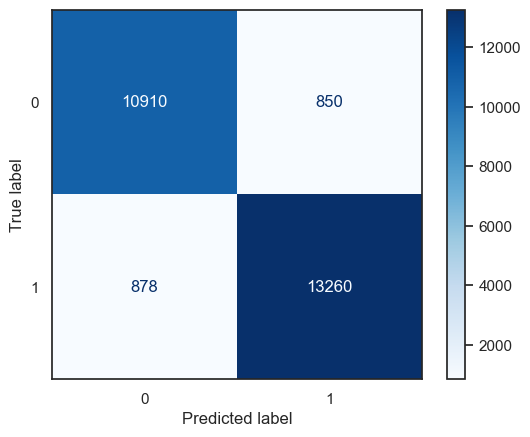

In [26]:
cm = confusion_matrix(y_valid, y_valid_pred, labels = decision_tree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = decision_tree.classes_)
disp.plot(cmap='Blues', values_format='d');

<details>
  <summary><h4><strong>Hint 1</strong></h4></summary>

Refer to [the content about plotting a confusion matrix](https://www.coursera.org/learn/regression-analysis-simplify-complex-data-relationships/lecture/SpRqe/evaluate-a-binomial-logistic-regression-model).

</details>

<details>
  <summary><h4><strong>Hint 2</strong></h4></summary>

Use `metrics.confusion_matrix`, `metrics.ConfusionMatrixDisplay`, and the `plot()` function.

</details>

**Question:** What patterns can you identify between true positives and true negatives, as well as false positives and false negatives?

- The confusion matrix shows that the model correctly predicted 13260 positive instances (True Positives) and 10910 negative instances (True Negatives).
- It made 850 false positive predictions (False Positives), where it predicted a positive class while the actual class was negative.
- It made 878 false negative predictions (False Negatives), where it predicted a negative class while the actual class was positive.
- The F1 score, which is the harmonic mean of precision and recall, is approximately 93.88%. It indicates a good balance between precision and recall.
- The model has an accuracy of approximately 93.33%. This means it correctly predicts the class label for about 93.33% of the instances.

### Plot the decision tree

Examine the decision tree. Use `plot_tree` function to produce a visual representation of the tree to pinpoint where the splits in the data are occurring.

In [27]:
unique_labels = df_subset['satisfaction'].unique()
print(unique_labels)

[1 0]


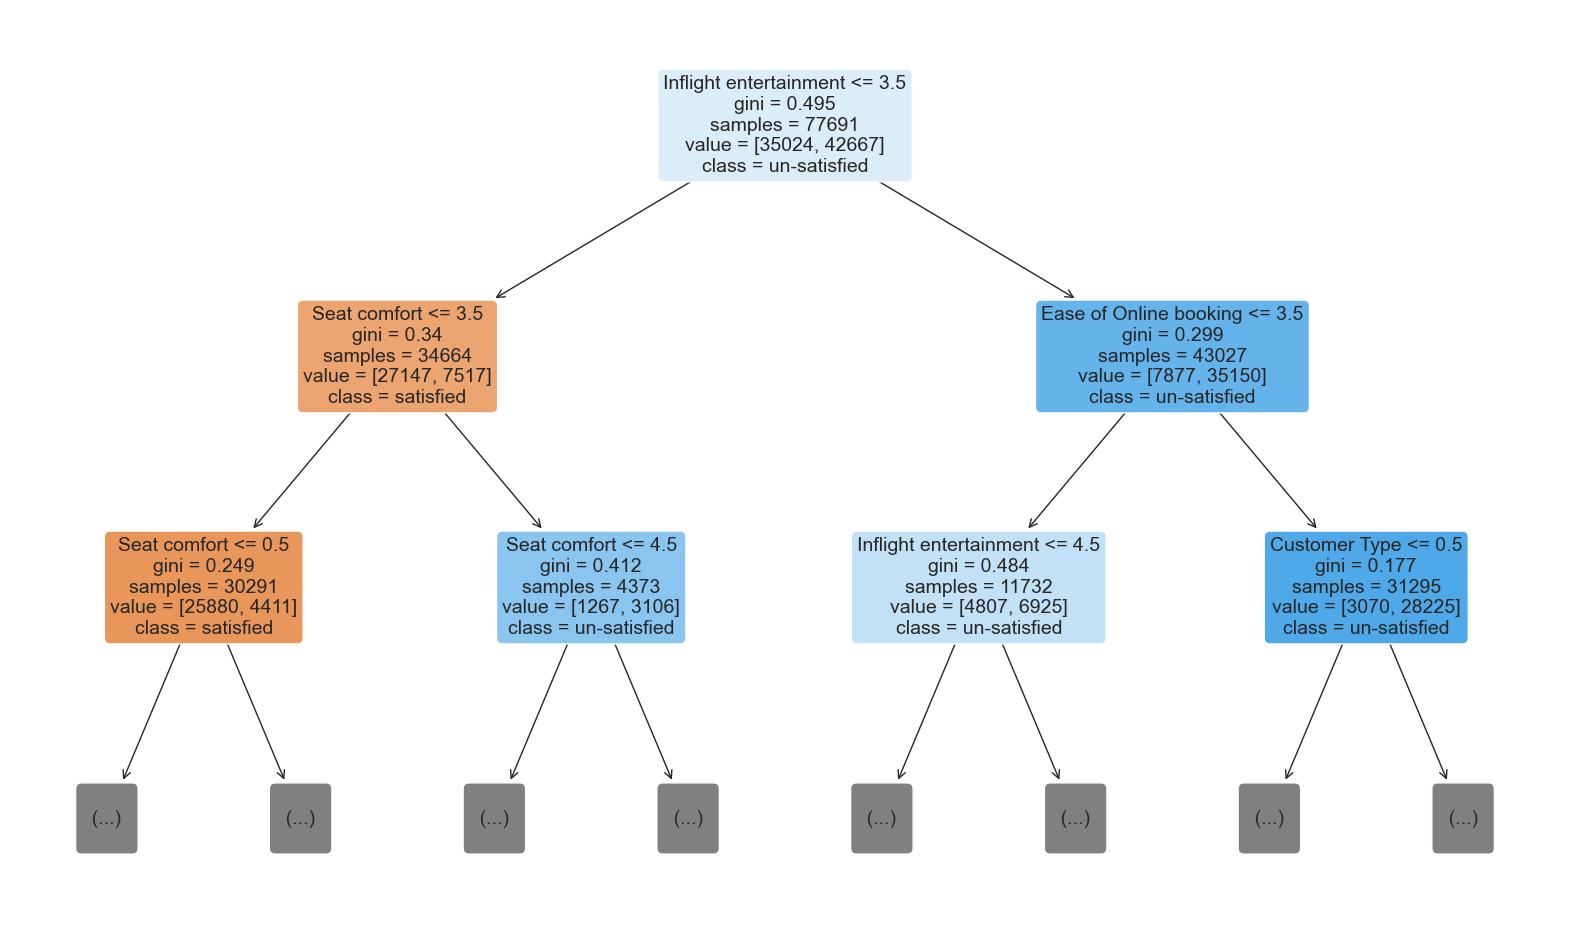

In [28]:
plt.figure(figsize=(20,12))
plot_tree(decision_tree, 
          filled=True, 
          rounded=True, 
          max_depth = 2, 
          feature_names=X.columns.tolist(),
          fontsize=14,
          label = 'all', 
          class_names = ['satisfied', 'un-satisfied']);

<details>
  <summary><h4><strong>Hint 1</strong></h4></summary>

If your tree is hard to read, pass `2` or `3` in the parameter `max_depth`. 

</details>

### BONUS STEP: Calculate feature importance

The `DecisionTreeClassifier` class comes with a [`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.feature_importances_) attribute that provides access to the features' relative importance in the model. The feature importances are computed when the `fit()` method is called on the `DecisionTreeClassifier` instance. In other words, it's information that is generated during model training. Here's how it works.

For each feature used in the tree, the algorithm finds all of the decision nodes that use that particular feature as the split criterion. Then for each of those decision nodes it computes the decrease in Gini impurity (or entropy, or log loss, or whatever metric you select when you fit the model&mdash;default is Gini impurity) that results from that split (so, the decrease from parent to children). Then the algorithm sums up the decreases across all the decisions made using that feature and expresses it as a percentage of the total decrease that resulted from _all_ features. 

Here is a simple example of how you can calculate feature importance from a tree diagram. This tree splits 10 samples using two features, X<sub>1</sub> and X<sub>2</sub>:

<img src='./SR-003_build_a_decision_tree_graphic.png'/>

Notice that the reduction in Gini impurity is weighted based on how many samples are in each node. Ultimately, the reduction that results from each feature is normalized (i.e., expressed as a percentage), and this percentage represents the importance of a given feature.

This can be interpreted as: X<sub>1</sub> is responsible for 73.7% of the overall reduction of Gini impurity in the model, and X<sub>2</sub> is responsible for 26.3% of the overall reduction of Gini impurity in the model.

Using the `feature_importances_` attribute to fetch the relative importances of each feature, you can then plot the results.

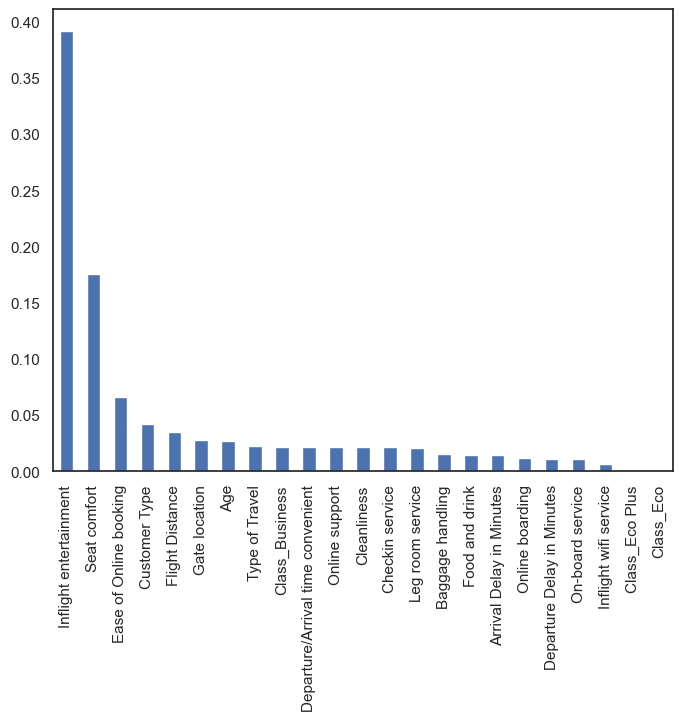

In [29]:
importances = decision_tree.feature_importances_

forest_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(8,6))
forest_importances.plot.bar(ax=ax);

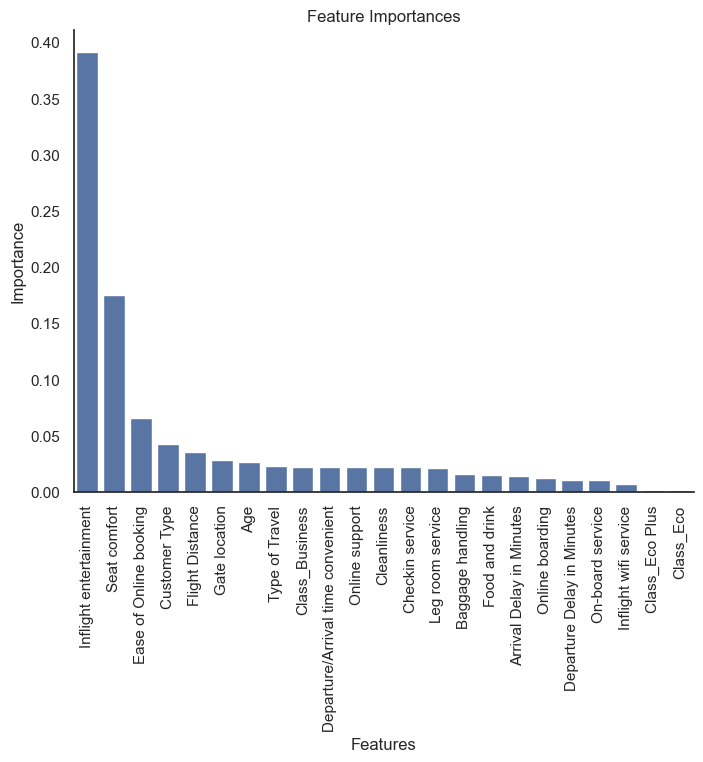

In [30]:
importances = decision_tree.feature_importances_
forest_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

# Create the plot using Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x=forest_importances.index, y=forest_importances.values, color=sns.color_palette()[0])
plt.xticks(rotation=90)  # Set the x-tick labels at a 45-degree angle
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
sns.despine();

The feature importance graph seems to confirm that `'Inflight entertainment'`, `'Seat comfort'`, and `'Ease of Online booking'` are the most important features for this model. 

### Hyperparameter tuning for `ccp_alpha` and `cv` before using GridSearchCV

Before using GridSearchCV for hyperparameter tuning, we can perform initial hyperparameter tuning for `ccp_alpha` and the number of cross-validation folds (`cv`) to get an idea of their impact on the model's performance. This can help us set a reasonable range of values for these hyperparameters before conducting an exhaustive search using `GridSearchCV`.
- `ccp_alpha` is the complexity parameter used for pruning the decision tree. It controls the trade-off between model complexity and accuracy. A larger `ccp_alpha` results in a simpler tree with fewer nodes and branches, which may reduce overfitting.
#### Choosing alpha

Alpha= 0

#### Cross Validation for Finding the Best Alpha

### Hyperparameter tuning using GridSearchCV

`GridSearchCV` in scikit-learn performs both **hyperparameter tuning** and **cross-validation** simultaneously.

Knowing how and when to adjust or tune a model can help a data professional significantly increase performance. In this section, you will find the best values for the hyperparameters `max_depth` and `min_samples_leaf` using grid search and cross validation. Below are some values for the hyperparameters `max_depth` and `min_samples_leaf`.   

In [31]:
tree_params = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 40, 50],
    'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 50]
}

scoring = ['accuracy', 'precision', 'recall', 'f1']

### Check combinations of values

Check every combination of values to examine which pair has the best evaluation metrics. Make a decision tree instance called `tuned_decision_tree` with `random_state=0`, make a `GridSearchCV` instance called `clf`, make sure to refit the estimator using `"f1"`, and fit the model on the training set. 

**Note:** This cell may take up to 15 minutes to run.

**F1 score** is usually more useful than accuracy, especially if you have an **uneven class** distribution. 

**Accuracy** works best if false positives and false negatives have **similar cost**. 

If the cost of false positives and false negatives are very different, it's better to look at both **Precision** and **Recall**.

In [32]:
tuned_decision_tree = DecisionTreeClassifier(random_state=42)

clf = GridSearchCV(estimator=tuned_decision_tree, 
                   param_grid=tree_params, 
                   scoring=scoring, 
                   cv=10, 
                   refit='f1')

clf.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 30, 40,
                                       50],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15,
                                              20, 50]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

<details>
  <summary><h4><strong>Hint 1</strong></h4></summary>

Refer to [the content about decision trees and grid search](https://www.coursera.org/learn/the-nuts-and-bolts-of-machine-learning/lecture/afopk/tune-a-decision-tree). 

</details>

<details>
  <summary><h4><strong> Hint 2</strong></h4></summary>

Use `DecisionTreeClassifier()`, `GridSearchCV()`, and the `clf.fit()` function.

</details>

**Question:** How can you determine the best combination of values for the hyperparameters? 

Use the best estimator tool to help uncover the best pair combination. 

### Compute the best combination of values for the hyperparameters

In [33]:
clf.best_estimator_

DecisionTreeClassifier(max_depth=16, min_samples_leaf=4, random_state=42)

<details>
  <summary><h4><strong> Hint 1</strong></h4></summary>

Use the `best_estimator_` attribute.

</details>

**Question:** What is the best combination of values for the hyperparameters? 

[Write your response here. Double-click (or enter) to edit.]

<strong> Question: What was the best average validation score? </strong>

In [34]:
print("Best Avg. Validation Score: ", "%.4f" % clf.best_score_)

Best Avg. Validation Score:  0.9429


[Write your response here. Double-click (or enter) to edit.]

<details>
  <summary><h4><strong>Hint 1</strong> </h4></summary>

Use the `.best_score_` attribute.

</details>

### Determine the "best" decision tree model's accuracy, precision, recall, and F1 score

Print out the decision tree model's accuracy, precision, recall, and F1 score. This task can be done in a number of ways. 

- The `cv_results_` attribute of a GridSearchCV object holds the results of the cross-validation performed during the grid search. It contains various metrics and information about each combination of hyperparameters.

- The `max` function returns the maximum value in the sequence. The `idxmax` function returns the index of the maximum value in the sequence.

In [35]:
### YOUR CODE HERE

results = pd.DataFrame(columns=['Model','F1','Recall','Precision','Accuracy', 'Best Parameters'])

def make_results(model_name, model_object):
    """
    Accepts as arguments a model name (your choice - string) and
    a fit GridSearchCV model object.

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean F1 score across all validation folds.  
    """
    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(mean f1 score)
    best_estimator_results = cv_results.iloc[cv_results['mean_test_f1'].idxmax(),:]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
    
    # Get the best hyperparameters
    best_params = model_object.best_params_
    
    # Create table of results
    table = pd.DataFrame()
    table = table.append({'Model': model_name,
                          'F1': f1,
                          'Recall': recall,
                          'Precision': precision,
                          'Accuracy': accuracy,
                          'Best Parameters': best_params},
                          ignore_index=True)
    return table

result_table = make_results("Tuned Decision Tree", clf)

result_table

C:\Users\Hp\AppData\Local\Temp\ipykernel_6528\605835937.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name,


,Model,F1,Recall,Precision,Accuracy,Best Parameters
0,Tuned Decision Tree,0.942902,0.933415,0.952619,0.937921,"{'max_depth': 16, 'min_samples_leaf': 4}"


In [36]:
def make_resultss(model_name, model_object):
    """
    Accepts as arguments a model name (your choice - string) and
    a fit GridSearchCV model object.

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the top 5 models with the best mean F1 scores across all validation folds.  
    """
    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Sort the cv_results based on the mean test F1 score in descending order
    cv_results_sorted = cv_results.sort_values(by='mean_test_f1', ascending=False)

    # Extract the top 5 rows (best 5 configurations) from the sorted DataFrame
    top_5_configs = cv_results_sorted.iloc[:5]

    # Extract accuracy, precision, recall, and f1 score for the top 5 configurations
    f1_values = top_5_configs['mean_test_f1']
    recall_values = top_5_configs['mean_test_recall']
    precision_values = top_5_configs['mean_test_precision']
    accuracy_values = top_5_configs['mean_test_accuracy']

    # Get the best hyperparameters for the top 5 configurations
    best_params_values = top_5_configs['params']

    # Create a DataFrame with the results of the top 5 configurations
    results_table = pd.DataFrame({
        'Model': [model_name] * 5,
        'F1': f1_values,
        'Recall': recall_values,
        'Precision': precision_values,
        'Accuracy': accuracy_values,
        'Best Parameters': best_params_values
    })

    return results_table

result_table = make_resultss("Tuned Decision Tree", clf)

print(result_table)

                   Model        F1    Recall  Precision  Accuracy  \
182  Tuned Decision Tree  0.942902  0.933415   0.952619  0.937921   
181  Tuned Decision Tree  0.942853  0.935477   0.950363  0.937728   
184  Tuned Decision Tree  0.942792  0.933602   0.952180  0.937779   
183  Tuned Decision Tree  0.942750  0.935196   0.950447  0.937625   
185  Tuned Decision Tree  0.942587  0.935313   0.949989  0.937432   

                              Best Parameters  
182  {'max_depth': 16, 'min_samples_leaf': 4}  
181  {'max_depth': 16, 'min_samples_leaf': 3}  
184  {'max_depth': 16, 'min_samples_leaf': 6}  
183  {'max_depth': 16, 'min_samples_leaf': 5}  
185  {'max_depth': 16, 'min_samples_leaf': 7}  


<details>
  <summary><h4><strong>Hint 1</strong></h4></summary>

Get all the results (`.cv_results_`) from the GridSearchCV instance (`clf`).

</details>

<details>
  <summary><h4><strong>Hint 2</strong></h4></summary>

Output `mean_test_f1`, `mean_test_recall`, `mean_test_precision`, and `mean_test_accuracy` from `clf.cv_results_`.
</details>

**Question:** Was the additional performance improvement from hyperparameter tuning worth the computational cost? Why or why not?

The F1 score for the decision tree that was not hyperparameter tuned is 0.938828 and the F1 score for the hyperparameter-tuned decision tree is 0.942902. While ensuring that overfitting doesn't occur is necessary for some models, it didn't make a meaningful difference in improving this model.

### Plot the "best" decision tree

Use the `plot_tree` function to produce a representation of the tree to pinpoint where the splits in the data are occurring. This will allow you to review the "best" decision tree.

In [37]:
plt.figure(figsize=(20,12))
plot_tree(clf.best_estimator_, 
          max_depth=2, 
          fontsize=14, 
          feature_names=X.columns, 
          filled=True, 
          rounded=True,  
          class_names=['No', 'Yes']);

InvalidParameterError: The 'feature_names' parameter of plot_tree must be an instance of 'list' or None. Got Index(['Customer Type', 'Age', 'Type of Travel', 'Flight Distance',
       'Seat comfort', 'Departure/Arrival time convenient', 'Food and drink',
       'Gate location', 'Inflight wifi service', 'Inflight entertainment',
       'Online support', 'Ease of Online booking', 'On-board service',
       'Leg room service', 'Baggage handling', 'Checkin service',
       'Cleanliness', 'Online boarding', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes', 'Class_Business', 'Class_Eco',
       'Class_Eco Plus'],
      dtype='object') instead.

<Figure size 2000x1200 with 0 Axes>

Which features did the model use first to sort the samples?

The plot makes it seem like `'Inflight entertainment'`, `'Seat comfort'`, and `'Ease of Online booking'` are among the most important features. The code below outputs a "most important" features graph from the model.

### BONUS STEP: Build another feature importance graph

You can build another feature importance graph to validate which features are most important.

In [ ]:
importances = clf.best_estimator_.feature_importances_

forest_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax);

The feature importance graph seems to confirm that `'Inflight entertainment'`, `'Seat comfort'`, and `'Ease of Online booking'` are the "most important" features for this model. 

**Question:** What do you think is the most important metric in this business case?

Any of the metrics in this business case could be considered important, depending on what the stakeholder or domain expert cares about. The following are reasons why each metric is important: 

- Accuracy tends to be the metric that the stakeholders can best understand.

- Precision measures what proportion of predicted positives is truly positive. For example, if you wanted to not falsely claiming a customer is satisfied, precision would be a good metric. Assuming a customer is happy when they are really not might lead to customer churn. 

- Recall measures the percentage of actual positives a model correctly identified (true positive). For this dataset, the airline might want to limit false negatives (actually satisfied people who are predicted to be unsatisfied). Assuming a customer is unhappy when the customer is happy can lead to the airline wasting resources trying to improve the customer experience of an already happy customer. 

- F1 balances precision and recall. It is the harmonic mean of precision and recall, or their product divided by their sum.

## Considerations

**What are some key takeaways that you learned from this lab?**
*   Machine learning workflows may be used to clean and encode data for machine learning.
*   While hyperparameter tuning can lead to an increase in performance, it doesn't always. 
*   The visualization of the decision tree as well as the feature graph can be used to determine which features are most important for a decision tree.


**What findings would you share with others?**
*   Decision trees accurately predicted satisfaction over 94 percent of the time.  
*   The confusion matrix is useful as it shows a similar number of true positives and true negatives. 
*   The visualization of the decision tree and the feature importance graph both suggest that `'Inflight entertainment'`, `'Seat comfort'`, and `'Ease of Online booking'` are the most important features in the model.

**What would you recommend to stakeholders?**
*  Customer satisfaction is highly tied to `'Inflight entertainment'`, `'Seat comfort'`, and `'Ease of Online booking'`. Improving these experiences should lead to better customer satisfaction. 
*  The success of the model suggests that the airline should invest more effort into model building and model understanding since this model semed to be very good at predicting customer satisfaction. 

**Congratulations!** You've completed this lab. However, you may not notice a green check mark next to this item on Coursera's platform. Please continue your progress regardless of the check mark. Just click on the "save" icon at the top of this notebook to ensure your work has been logged